In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn            import preprocessing 
from sklearn.metrics    import mean_squared_error, mean_absolute_percentage_error
from sklearn.neighbors  import KNeighborsRegressor

from sktime.forecasting.arima               import ARIMA
from sktime.forecasting.base                import ForecastingHorizon
from sktime.forecasting.trend               import PolynomialTrendForecaster
from sktime.forecasting.statsforecast       import StatsForecastAutoARIMA
from sktime.forecasting.compose             import TransformedTargetForecaster
from sktime.transformations.series.detrend  import Deseasonalizer,Detrender

from sktime.forecasting.theta               import ThetaForecaster

In [47]:
#add path of getNewestData.py to sys.path
import sys,os
sys.path.append("../../../data")

from getNewestData import resample_fix_ends, reassign_outliers

In [48]:
pdf = pd.read_csv("../../../data/daily/ewz_stromabgabe_netzebenen_stadt_zuerich.csv",index_col=None)
pdf.index = pd.to_datetime(pdf['Timestamp'],utc=True)
pdf.index = pdf.index.tz_localize(None)  

pdf["y"] = pdf["NE7_GWh"].values
pdf = pdf.drop(columns=["Timestamp","NE5_GWh","NE7_GWh"])

#split data in train val and test
#2657/365/(days since first december last year) 
include_validation = False

if include_validation:
    n_test = (pdf.index[-1] -pd.to_datetime("2022-11-30")).days
    split = len(pdf)-365-n_test
    pdf_train, pdf_val, pdf_test = pdf.iloc[:split], pdf.iloc[split:split+365], pdf.iloc[split+365:]

else: 
    n_test = (pdf.index[-1] -pd.to_datetime("2022-07-31")).days
    split = len(pdf)-n_test
    pdf_train, pdf_test = pdf.iloc[:split], pdf.iloc[split:]

In [49]:
forecaster = TransformedTargetForecaster(
    [
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ("deseasonalize", Deseasonalizer(model="additive", sp=7)),
        ("deseasonalize", Deseasonalizer(model="additive", sp=365)),
        ("forecast", ARIMA() )  
        #("forecast", regressor )
    ]
)

#forecaster = make_reduction(regressor, window_length=15, strategy="recursive")

#forecaster = ThetaForecaster(sp=7)  

y_train = pdf_train['y'].squeeze().asfreq(freq='D')
forecaster.fit(y_train)
horizon = ForecastingHorizon(pdf_test.index, is_relative=False)
y_pred  = forecaster.predict(fh=horizon)


In [50]:
#use validation set to improve model. 

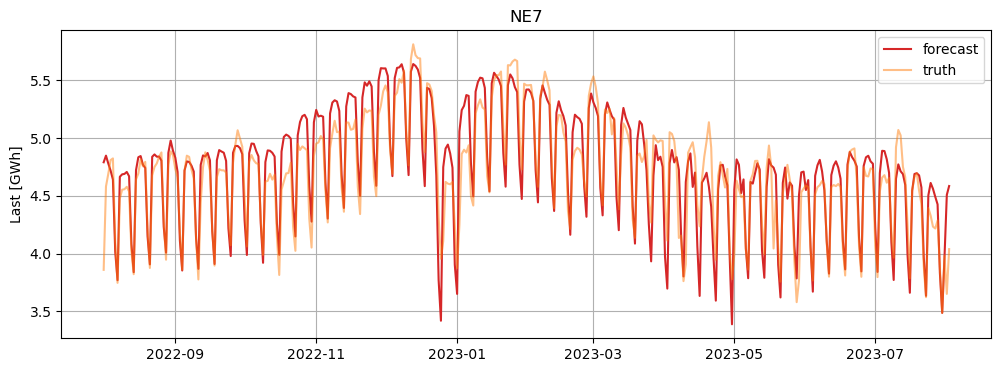

In [51]:
f, axes = plt.subplots(1, 1, figsize=(12, 4))


axes.plot(y_pred, color="tab:red", label="forecast")
# axes.plot(pdfTrain.ds.values, pdfTrain.y.values, color="tab:blue", label="train")
axes.plot(pdf_test, color="tab:orange", label="truth", alpha=0.5)
axes.legend()
axes.set_title("NE7")
axes.set_ylabel("Last [GWh]")
axes.grid()

# xmin, xmax = axes[0].get_xlim()
# axes[1].plot(pdf_test.index, (y_pred.values - pdf_test.y.values)*100) # / (pdf_test.y.values+y_pred.values)*100)
# axes[1].set_xlim(xmin, xmax)
# axes[1].set_ylabel("residual: (Pred-True)/True [%]")

plt.show()

In [52]:
print(f"RMSE: {mean_squared_error(y_pred, pdf_test.y.values, squared=False)}")
print(f"MAPE: {mean_absolute_percentage_error(y_pred, pdf_test.y.values)}")

RMSE: 0.2194481953935552
MAPE: 0.03519376980878385


### Better apply monthly Aggregation or directly train on Monthly? 

#### Aggregate the daily forecasts to monthly forecasts

In [53]:
prediction = y_pred
test = pdf_test

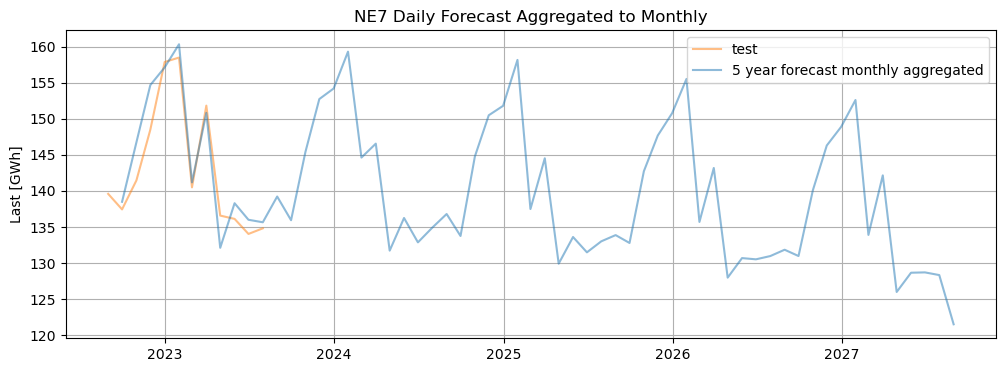

In [54]:
f, axes = plt.subplots(1, 1, figsize=(12, 4))

prediction  = resample_fix_ends(prediction, "M")
test        = resample_fix_ends(test, "M")
axes.plot(test, color="tab:orange", label="test", alpha=0.5)


fiveyears = pd.date_range(start=test.index[0] , periods=365*5, freq="D")
horizon = ForecastingHorizon(fiveyears, is_relative=False)
fiveYearPrediction  = forecaster.predict(fh=horizon)

axes.plot(resample_fix_ends(fiveYearPrediction, "M"), color="tab:blue", label="5 year forecast monthly aggregated", alpha=0.5)
axes.legend()
axes.set_title("NE7 Daily Forecast Aggregated to Monthly")
axes.set_ylabel("Last [GWh]")
axes.grid()

plt.show()

In [55]:
print(f"RMSE: {mean_squared_error(prediction.y.values, test.y.values, squared=False)}")

RMSE: 2.9957201053255877


## Train directly on Monthly

In [56]:
if include_validation:
    pdf_val   = resample_fix_ends(pdf_val, "M")

pdf_train = resample_fix_ends(pdf_train, "M")
pdf_test  = resample_fix_ends(pdf_test, "M")

In [57]:

forecaster = TransformedTargetForecaster(
    [
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ("deseasonalize", Deseasonalizer(model="additive", sp=12)),
        ("forecast", ARIMA() )  
        #("forecast", regressor )
    ]
)


idx = pd.period_range(start=pdf_train.index[0], end= pdf_train.index[-1], freq="M")
y_train = pd.Series(pdf_train.y.values, index=idx)

forecaster.fit(y_train)


TransformedTargetForecaster(steps=[('detrend',
                                    Detrender(forecaster=PolynomialTrendForecaster())),
                                   ('deseasonalize', Deseasonalizer(sp=12)),
                                   ('forecast', ARIMA())])

In [58]:
idx = pd.period_range(start=pdf_test.index[0], end= pdf_test.index[-1], freq="M")
horizon = ForecastingHorizon(idx, is_relative=False)
y_pred  = forecaster.predict(fh=horizon)

In [59]:
idx = pd.period_range(start=pdf_train.index[0], end= pdf_train.index[-1], freq="M")
horizon = ForecastingHorizon(idx, is_relative=False)

fit  = forecaster.predict(fh=horizon)

In [60]:
idx = pd.period_range(start=pdf_test.index[0], periods=60, freq="M")
horizon = ForecastingHorizon(idx, is_relative=False)

five_years  = forecaster.predict(fh=horizon)

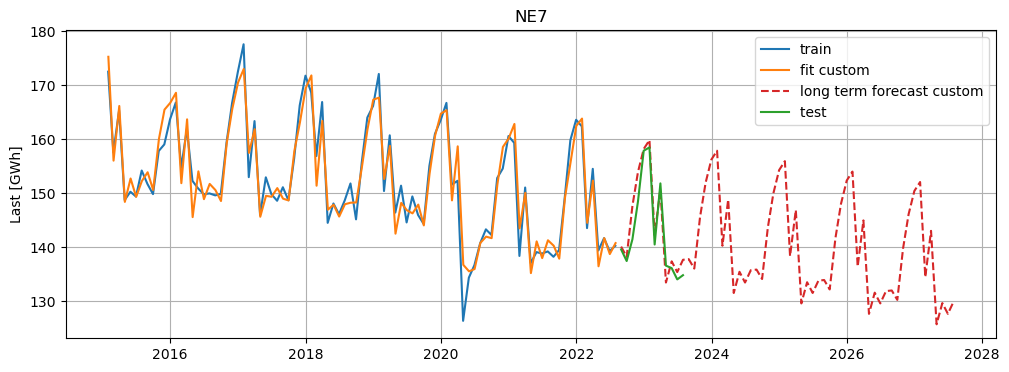

In [61]:
f, axes = plt.subplots(1, 1, figsize=(12, 4))

axes.plot(pdf_train, color="tab:blue", label="train")
axes.plot(fit.index.to_timestamp(how="end"), fit.values, color="tab:orange", label="fit custom")
#axes.plot(y_pred.index.to_timestamp(how="end"), y_pred.values, color="tab:red", label="forecast custom")
axes.plot(five_years.index, five_years.values, color="tab:red", linestyle="--",label="long term forecast custom")
axes.plot(pdf_test, color="tab:green", label="test ")
axes.legend()
axes.set_title("NE7")
axes.set_ylabel("Last [GWh]")
axes.grid()
plt.show()

In [62]:
print(f"RMSE: {mean_squared_error(y_pred.values, pdf_test.values, squared=False)}")

RMSE: 2.826432936525285
